# Cell Lineage from Normalized Covariance (CLiNC)

This notebook provides methods to reconstruct a cell type hierarchy from clonal barcoding data, and to detect differnetiation pathways that violate the hierarchy. The code below is sufficient to reproduce the panels from Figure 5 in REF.

### Algorithm overview

The input data is a matrix of barcode counts in across cell types. In principle these counts should represent numbers of cells (as opposed to numbers of sequencing reads). The output is an inferred cell type hierarchy and a list of putative tree violations. The only parameter is the false-discovery rate for detection of conformal symmetry violations (default 5%). The CLiNCs pipeline includes the following steps:

1. Calculate normalized covariance between each pair of cell types
2. Use neighbor-joining to iterative form a cell type hierarchy
3. Identify statistically significant deviations from conformal symmetry
4. Use symmetry violations to infer putative differentiation pathways that violate the hierarchy


### Initialize parameters and imports

In [1]:
# ! pip3 install fastcluster --user
import sys
sys.path.append('/Users/mortlockrd/Library/Python/3.7/lib/python/site-packages/')
import fastcluster as fastcluster

# ! pip3 install SetCoverPy --user
import sys
sys.path.append('/Users/mortlockrd/Library/Python/3.7/lib/python/site-packages/')
import SetCoverPy as SetCoverPy

import sys
sys.path.append('../')
import clinc.clinc_util as cu

input_data_path = 'barcode_sample_data_6m.txt'
output_directory = 'example_output_rdm'
symmetry_violation_FDR = 0.05

cu.make_output_dir(output_directory)

### Load input data
Input data should consist of a matrix where each row is a barcoded clone, each column is a cell type, and each entry is a count of cells (the number of cells from the clone in the cell type). Data should be provided as a tab-delimited (tsv) file, with a header consisting of celltype names. Please do not include a label-column (i.e. all columns contain counts data). See example file loaded below. 

Loaded 25560 barcodes in 5 cell types


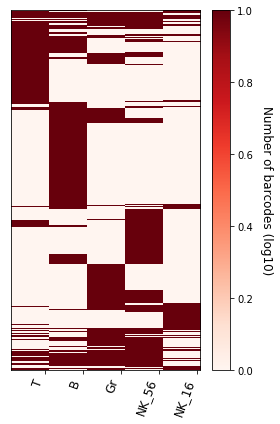

In [2]:
barcode_counts, celltype_names = cu.load_data(input_data_path)
cu.plot_barcode_counts(output_directory, barcode_counts, celltype_names)

(See Figure 5B) The heatmap shows the number of cells with each barcode in each cell type.

### 1. Calculate normalized covariance

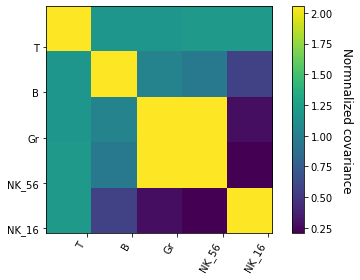

In [3]:
X = cu.get_normalized_covariance(barcode_counts)
cu.plot_normalized_covariance(output_directory, X, celltype_names)

### 2. Use neighbor-joining to iterative form a cell type hierarchy

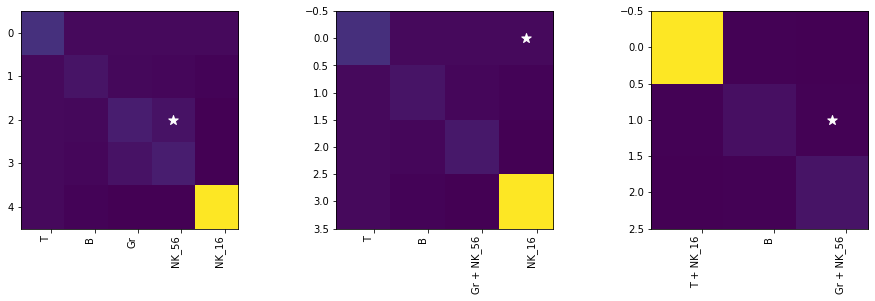

In [4]:
parent_map, node_groups, plot_data = cu.build_hierarchy(barcode_counts)
cu.plot_neighbor_joining(output_directory, node_groups, celltype_names, *plot_data)

(See Figure 5C) Lineages with the highest normalized covariance of barcode abundance are progressively merged

In [7]:
# ! pip3 install ete3 --user
import sys
sys.path.append('/Users/mortlockrd/Library/Python/3.7/lib/python/site-packages/')
import ete3 as ete3

In [8]:
cu.print_hierarchy(parent_map, celltype_names)


         /-NK_56
      /-|
   /-|   \-Gr
  |  |
--|   \-B
  |
  |   /-NK_16
   \-|
      \-T


(See Figure 5D) Dendrogram representing the lineage relations predicted by neighbor-joining

### 3. Identify statistically significant deviations from conformal symmetry

Detected 3 instances of symmetry violation passing a threshold of 0.18574792614801292 with FDR 0.02


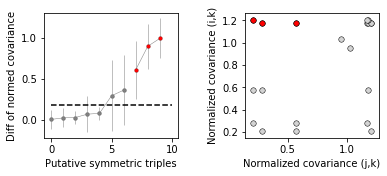

In [9]:
violations, plot_data = cu.detect_symmetry_violations(barcode_counts, parent_map, .02)
cu.plot_violations(output_directory, *plot_data)

(See Figure 5E) LEFT: All triples (i,j,k) (dots) representing symmetries predicted by the tree (i.e. C_jk symmetric to C_ik are ranked by the difference C_jk-C_ik with uncertainty in the difference plotted with 90% confidence interval. RIGHT: All triples (i,j,k) plotted by the pair of normalized covariances C_jk and C_ik. When the 90% bootstrap confidence interval (CI) exceeds ϵ=median(C_jk-C_ik )=1.93, the triple is classified as a symmetry violation (red dots; LEFT and RIGHT plots). 


### 4. Infer putative differentiation pathways that violate the hierarchy

In [10]:
final_transitions, num_violations_predicted, num_violations_explained, total_explained, all_transitions, all_costs, all_predicted = cu.detect_cross_tree_transitions(parent_map, violations, barcode_counts.shape[1])


/Users/mortlockrd/Library/Python/3.7/lib/python/site-packages/SetCoverPy/setcover.py:241: RuntimeWarning: divide by zero encountered in true_divide
  adjusted_cost = self.c/self.a_csc.dot(np.ones(self.mrows))
/Users/mortlockrd/Library/Python/3.7/lib/python/site-packages/SetCoverPy/setcover.py:242: RuntimeWarning: invalid value encountered in multiply
  cost_matrix = adjusted_cost*self.a + np.amax(adjusted_cost)*(~self.a)
/Users/mortlockrd/Library/Python/3.7/lib/python/site-packages/SetCoverPy/setcover.py:350: RuntimeWarning: invalid value encountered in double_scalars
  Lu_sequence[0] = np.einsum('i->', cost_u[cost_u<0])+np.einsum('i->', u_sequence[:,0])
/Users/mortlockrd/Library/Python/3.7/lib/python/site-packages/SetCoverPy/setcover.py:365: RuntimeWarning: invalid value encountered in less
  u_temp[u_temp<0] = 0
/Users/mortlockrd/Library/Python/3.7/lib/python/site-packages/SetCoverPy/setcover.py:370: RuntimeWarning: invalid value encountered in less
  Lu_sequence[i+1] = np.einsum('i-

This Best solution: UB=1.0, LB=0.9887540046344776, UB1=1.0, LB1=0.9887540046344776
Current Best Solution: UB=1.0, LB=0.9887540046344776, change=1.1245995365522399% @ niters=0
Current Best Solution: UB=1.0, LB=0.9999999968460691, change=3.1539308942285516e-07% @ niters=3
Final Best solution: 1.0
Took 0.004 minutes to reach current solution.


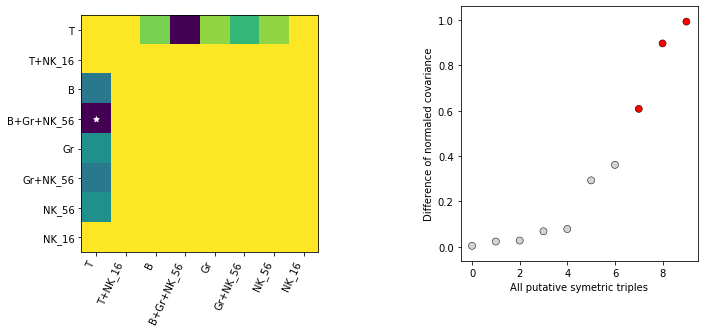

In [11]:
cu.plot_cross_tree_transitions(output_directory, all_costs, all_predicted, all_transitions, final_transitions, parent_map, celltype_names, node_groups, *plot_data)

(See Figure 5F) LEFT: For each cross-tree transition, defined by a source node (heatmap columns) and a target node (heatmap rows), the cost function – representing the proportion of predicted violations that match the observed violations – is plotted (intensity in heatmap). The transitions that minimize cost and cover the predicted violations are marked by an asterisk. RIGHT: Putative symmetric triples ranked by difference of normalized covariance. The symmetry violations predicted by the detected cross-tree transitions are colored red. 

In [12]:
cu.print_cross_tree_transitions(final_transitions, num_violations_predicted, num_violations_explained, total_explained, len(violations), node_groups, celltype_names)


3 out of 3 symmetry violations can be explained by the following cross-tree transitions:

Explained symmetry violations    Proportion matching    Transition
3                                1.0                    B+Gr+NK_56 -> T


### 5. Flag possible distortions and apply post-hoc tree correction 

In [14]:
reject_transitions, parent_map_edit = cu.detect_distortions(final_transitions, parent_map)
cu.print_distortions(reject_transitions, parent_map_edit, celltype_names)

No disortions were found
